In [2]:
import torch
import matplotlib.pyplot as plt

from models.wta_cnp import WTA_CNP
from data.data_generators import *

if torch.cuda.is_available():
    device = torch.device("cuda:0")
else:
    device = torch.device("cpu")

In [3]:
# Hyperparameters
batch_size = 32
n_max_obs, n_max_tar = 6, 6

t_steps = 200
num_demos = 128
num_classes = 4
num_indiv = num_demos//num_classes  # number of demos per class
noise_clip = 0.0
dx, dy = 1, 1

num_val = 32
num_val_indiv = num_val//num_classes

colors = ['r', 'g', 'b', 'm']

X: torch.Size([128, 200, 1]) Y: torch.Size([128, 200, 1]) VX: torch.Size([32, 200, 1]) VY: torch.Size([32, 200, 1])


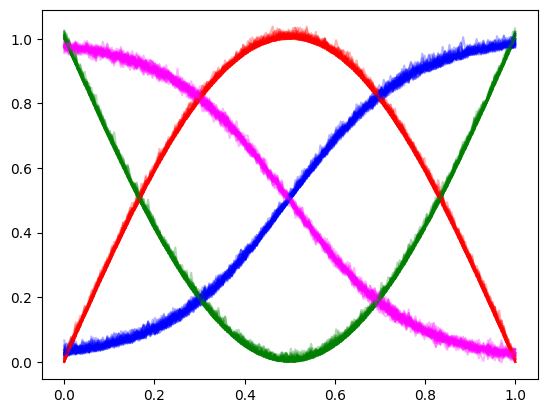

In [4]:
# Generating the data
x = torch.linspace(0, 1, 200).repeat(num_indiv, 1)
y = torch.zeros(num_demos, t_steps, dy)

vx = torch.linspace(0, 1, 200).repeat(num_val_indiv, 1)
vy = torch.zeros(num_val, t_steps, dy)

generator_functions = [generate_sin, generate_cos, generate_cx_sigm, generate_reverse_cx_sigm]

for i in range(num_classes):
    noise = torch.clamp(torch.randn(x.shape)*1e-4**0.5, min=0) - noise_clip
    y[i*num_indiv:(i+1)*num_indiv] = torch.unsqueeze(generator_functions[i](x) + noise, 2)
    noise = torch.clamp(torch.randn(vx.shape)*1e-4**0.5, min=0) - noise_clip
    vy[i*num_val_indiv:(i+1)*num_val_indiv] = torch.unsqueeze(generator_functions[i](vx) + noise, 2)

x = torch.unsqueeze(x.repeat(num_classes, 1), 2)  # since dx = 1
vx = torch.unsqueeze(vx.repeat(num_classes, 1), 2)
print("X:", x.shape, "Y:", y.shape, "VX:", vx.shape, "VY:", vy.shape)

for i in range(num_indiv):
    plt.plot(x[i, :, 0], y[i, :, 0], 'r', alpha=0.3)
    plt.plot(x[i+num_indiv, :, 0], y[i+num_indiv, :, 0], 'g', alpha=0.3)
    plt.plot(x[i+2*num_indiv, :, 0], y[i+2*num_indiv, :, 0], 'b', alpha=0.3)
    plt.plot(x[i+3*num_indiv, :, 0], y[i+3*num_indiv, :, 0], 'magenta', alpha=0.3)
plt.show()

x, y = x.to(device), y.to(device)

In [5]:
def get_batch(x, y, traj_ids):
    n_t = torch.randint(1, n_max_tar, (1,)).item()
    n_o = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, n_o, dx+dy, device=device)
    tar = torch.zeros(batch_size, n_t, dx, device=device)
    tar_val = torch.zeros(batch_size, n_t, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:n_o]
        t_ids = random_query_ids[n_o:n_o+n_t]

        obs[i, :, :] = torch.cat((x[traj_ids[i], o_ids], y[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = x[traj_ids[i], t_ids]
        tar_val[i, :, :] = y[traj_ids[i], t_ids]

    # print("Obs:", obs.shape, "Tar:", tar.shape, "Tar_val:", tar_val.shape)
    return obs, tar, tar_val

def get_validation_batch(vx, vy, traj_ids, device=device):
    num_obs = torch.randint(1, n_max_obs, (1,)).item()

    obs = torch.zeros(batch_size, num_obs, dx+dy, device=device)
    tar = torch.zeros(batch_size, t_steps, dx, device=device)
    tar_val = torch.zeros(batch_size, t_steps, dy, device=device)

    for i in range(len(traj_ids)):
        random_query_ids = torch.randperm(t_steps)
        o_ids = random_query_ids[:num_obs]

        obs[i, :, :] = torch.cat((vx[traj_ids[i], o_ids], vy[traj_ids[i], o_ids]), dim=-1)
        tar[i, :, :] = vx[traj_ids[i]]
        tar_val[i, :, :] = vy[traj_ids[i]]

    return obs, tar, tar_val

In [9]:
import wandb

sweep_config = {
    'method': 'random',
    'name': 'sweep',
    'metric': {'goal': 'minimize', 'name': 'val_epoch_err'},
    'parameters': 
    {
        'nll_coeff': {'max': 10.0, 'min': 0.1},
        'other_loss_coeff': {'max': 10.0, 'min': 0.1}
     }
}

#sweep_id = wandb.sweep(
#  sweep=sweep_config,
#  project='wta-loss-components-sweep'
#  )
sweep_id = 'z1mhmtvm'

Create sweep with ID: z1mhmtvm
Sweep URL: https://wandb.ai/yildirimyigit/wta-loss-components-sweep/sweeps/z1mhmtvm


In [10]:
import time

def model_train():
    run = wandb.init()
    nll_coeff = wandb.config.nll_coeff
    other_loss_coeff = wandb.config.other_loss_coeff

    model = WTA_CNP(1, 1, 6, 6, [128, 128, 256], num_decoders=4, decoder_hidden_dims=[256, 128, 128], batch_size=batch_size, nll_coeff=nll_coeff, other_loss_coeff=other_loss_coeff).to(device)
    optimizer = torch.optim.Adam(lr=1e-4, params=model.parameters())

    file_name = int(time.time())

    epochs = 1_500_000
    epoch_iter = num_demos//batch_size  # number of batches per epoch (e.g. 100//32 = 3)
    v_epoch_iter = num_val//batch_size  # number of batches per validation (e.g. 100//32 = 3)
    avg_loss = 0

    val_per_epoch = 1000
    min_val_error = 1000000

    mse_loss = torch.nn.MSELoss()

    for epoch in range(epochs):
        epoch_loss = 0

        traj_ids = torch.randperm(x.shape[0])[:batch_size*epoch_iter].chunk(epoch_iter)  # [:batch_size*epoch_iter] because nof_trajectories may be indivisible by batch_size

        for i in range(epoch_iter):
            optimizer.zero_grad()
            obs, tar_x, tar_y = get_batch(x, y, traj_ids[i])
            pred, gate = model(obs, tar_x)
            loss, nll = model.loss(pred, gate, tar_y)
            loss.backward()
            optimizer.step()

            epoch_loss += nll.item()

        if epoch % val_per_epoch == 0:
            with torch.no_grad():
                v_traj_ids = torch.randperm(vx.shape[0])[:batch_size*v_epoch_iter].chunk(v_epoch_iter)
                
                val_epoch_err = 0

                for j in range(v_epoch_iter):
                    o, t, tr = get_validation_batch(vx, vy, v_traj_ids[j])
                    p, g = model(o, t)
                    dec_id = torch.argmax(g.squeeze(1), dim=-1)
                    vp_means = p[dec_id, torch.arange(batch_size), :, :dy]
                    val_epoch_err += mse_loss(vp_means, tr).item()

                if val_epoch_err < min_val_error:
                    min_val_error = val_epoch_err
                    print(f'New best: {min_val_error}')
                    torch.save(model.state_dict(), f'saved_models/wtacnp_synth_{file_name}.pt')

                wandb.log({
                    'epoch': epoch, 
                    'train_loss': avg_loss/99.0, 
                    'val_epoch_err': val_epoch_err
                })


        avg_loss += epoch_loss

        if epoch % 100 == 0:
            print("Epoch: {}, Loss: {}".format(epoch, avg_loss/100))
            avg_loss = 0

In [11]:
wandb.agent(sweep_id, function=model_train, count=16, project='wta-loss-components-sweep')

wandb: Agent Starting Run: dulup9w8 with config:
wandb: 	nll_coeff: 0.34542646834718505
wandb: 	other_loss_coeff: 8.103904595580843
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
/usr/lib/python3/dist-packages/requests/__init__.py:87: RequestsDependencyWarning: urllib3 (2.0.3) or chardet (4.0.0) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "
wandb: Currently logged in as: yildirimyigit. Use `wandb login --relogin` to force relogin


New best: 0.3501494824886322
Epoch: 0, Loss: 0.03801522433757782
Epoch: 100, Loss: 1.604936829507351
Epoch: 200, Loss: 1.4106925325095654
Epoch: 300, Loss: 1.3780180513858795
Epoch: 400, Loss: 1.3637296417355538
Epoch: 500, Loss: 1.3554512557387353
Epoch: 600, Loss: 1.3219152721762657
Epoch: 700, Loss: 1.2844870914518833
Epoch: 800, Loss: 1.2121753906458617
Epoch: 900, Loss: 1.1619471786171198
New best: 0.0998392254114151
Epoch: 1000, Loss: 1.036697355285287
Epoch: 1100, Loss: 0.9419227619841695
Epoch: 1200, Loss: 0.8688193574547768
Epoch: 1300, Loss: 0.802445762483403
Epoch: 1400, Loss: 0.7625225528888404
Epoch: 1500, Loss: 0.7008005233202129
Epoch: 1600, Loss: 0.6486856228206307
Epoch: 1700, Loss: 0.6060324624041096
Epoch: 1800, Loss: 0.6171832778397948
Epoch: 1900, Loss: 0.5377027751901187
New best: 0.07611752301454544
Epoch: 2000, Loss: 0.5343386789457872
Epoch: 2100, Loss: 0.5257882066816092
Epoch: 2200, Loss: 0.42810173720354217
Epoch: 2300, Loss: 0.4301221917103976
Epoch: 2400, 

wandb: Ctrl + C detected. Stopping sweep.


Epoch: 2688100, Loss: -12.549480049610137
Epoch: 2688200, Loss: -12.427827171385289
Epoch: 2688300, Loss: -12.368905682563781
Epoch: 2688400, Loss: -12.02799805343151
Epoch: 2688500, Loss: -12.134448376595975
Epoch: 2688600, Loss: -12.426812205314636
Epoch: 2688700, Loss: -11.889075914621353
Epoch: 2688800, Loss: -12.233730709552765
Epoch: 2688900, Loss: -12.47913750886917
Epoch: 2689000, Loss: -12.314971330165863
Epoch: 2689100, Loss: -12.414802660942078
Epoch: 2689200, Loss: -12.466578311920166
Epoch: 2689300, Loss: -12.469310643672943
Epoch: 2689400, Loss: -12.504648184776306
Epoch: 2689500, Loss: -12.454301731586456
Epoch: 2689600, Loss: -12.458482267856597
Epoch: 2689700, Loss: -12.427034800052644
Epoch: 2689800, Loss: -12.173007605075837
Epoch: 2689900, Loss: -12.235321216583252
Epoch: 2690000, Loss: -12.382483701705933
Epoch: 2690100, Loss: -12.470452950000762
Epoch: 2690200, Loss: -12.486513456106186
Epoch: 2690300, Loss: -12.571484761238098
Epoch: 2690400, Loss: -12.3688459479

In [7]:
# Testing the best model
# model = WTA_CNP(1, 1, 10, 10, [256, 256, 256], 4, [128, 128], batch_size)
# model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_{file_name}.pt'))
# model.eval()

# o, t, tr = get_validation_batch(vx, vy)

# with torch.no_grad():
#     p, g = model(o, t)

# p, g = p.cpu().numpy(), g.cpu()
# t, tr = t.cpu().numpy(), tr.cpu().numpy()

# for i in range(batch_size):
#     dec_id = torch.argmax(g[i, :, :]).item()
#     print(dec_id)
#     plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.3)

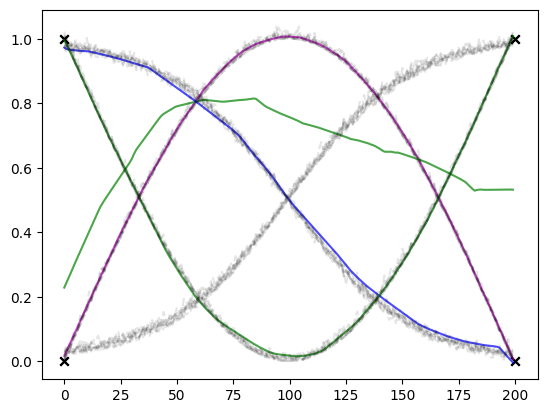

In [9]:
### TESTING

# def generate_test_batch(n=4):
#     obs = torch.zeros(n, 2, 2)
#     obs[0] = torch.tensor([[0, 0], [1, 0]])
#     obs[1] = torch.tensor([[0, 0], [1, 1]])
#     obs[2] = torch.tensor([[0, 1], [1, 0]])
#     obs[3] = torch.tensor([[0, 1], [1, 1]])
#     tar = vx[:4, torch.arange(t_steps)]

#     return obs, tar


# model = WTA_CNP(1, 1, 6, 6, [128, 128, 256], num_decoders=4, decoder_hidden_dims=[256, 128, 128], batch_size=4)
# model.load_state_dict(torch.load(f'saved_models/wtacnp_synth_{file_name}.pt'))
# model.eval()

# o, t = generate_test_batch()

# # print(o)

# with torch.no_grad():
#     p, g = model(o, t)

# p, g = p.cpu().numpy(), g.cpu()

# for i in range(4):

#     # print(o[i, 0, 0], o[i, 0, 1], o[i, 1, 0], o[i, 1, 1])

#     dec_id = torch.argmax(g[i, :, :]).item()
#     plt.plot(range(t_steps), p[dec_id, i, :, 0], colors[dec_id], alpha=0.7)

#     plt.scatter(o[i, 0, 0]*200, o[i, 0, 1], color='k', marker='x')
#     plt.scatter(o[i, 1, 0]*200, o[i, 1, 1], color='k', marker='x')

# for i in range(32):
#     plt.plot(range(t_steps), tr[i, :, 0].cpu().numpy(), 'k', alpha=0.1, linestyle='dashed')

# plt.show()

In [ ]:
# pytorch_total_params = sum(p.numel() for p in model.parameters())
# print(pytorch_total_params)
# pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
# print(pytorch_total_params)

166662
166662
